# Experiments

- **author:** JB Cabral (<jbc.develop@gmail.com>)

In [1]:
% matplotlib inline

import os
import sys
import tempfile

sys.path.append("..")

import numpy as np

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

import sklearn
from sklearn import feature_selection as fs
from sklearn import preprocessing as prp
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display as d

from lime import lime_tabular as lt

from joblib import Memory

from libs import fourier_help

import pytff

pd.options.mode.chained_assignment = None 



## 1. Load Data

In [2]:
tile = pd.DataFrame(np.load("/home/data/carpyncho/stored/npy_tiles/cat_b278_jhk_1.npy"))

In [3]:
ogle3 = pd.read_table("../data/ogle_rr.txt", header=6)
ogle3.columns

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'# ID', u'Field', u'StarID', u'RA', u'Decl', u'Type', u'I', u'V',
       u'P_1', u'dP_1', u'T0_1', u'A_1', u'R21_1', u'phi21_1', u'R31_1',
       u'phi31_1', u'P_2', u'dP_2', u'T0_2', u'A_2', u'R21_2', u'phi21_2',
       u'R31_2', u'phi31_2', u'ID_OGLE_II', u'ID_MACHO', u'ID_GCVS',
       u'ID_OTHER', u'Remarks'],
      dtype='object')

In [4]:
path = "/home/data/carpyncho/stored/samples/b278_sample.npy"
df = pd.DataFrame(np.load(path))

In [5]:
obs = pd.read_pickle("../data/rrb278_obs.pkl")

##  2. Preprocess

### 2.1. Discretize the classes

In [6]:
classes = set(df.ogle3_type)
sclasses_names = set(c.split("-", 1)[0] for c in classes)
classes = dict(zip(sorted(classes), range(len(classes))))
sclasses = dict(zip(sorted(sclasses_names), range(len(sclasses_names))))

df["cls"] = df.ogle3_type.apply(classes.get)
df["scls"] = df.ogle3_type.apply(lambda v: sclasses.get(v.split("-", 1)[0]))
    
d.display(d.Markdown("### Classes"))
d.display(classes)

d.display(d.Markdown("### Simplified Classes"))
d.display(sclasses)

### Classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

### Simplified Classes

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

In [11]:
def get_o3id(o3id):
    return ogle3[ogle3["# ID"] == o3id].P_1.values[0]
    
rr = df[df.scls == 3]
rr["ogle3_id"] = rr.id.apply(lambda cid: tile[tile.id == cid].ogle3_id.values[0])
rr["ogle3_period"] = rr.ogle3_id.apply(get_o3id)
rr["fvo3_p"] = np.abs(rr.PeriodLS - rr.ogle3_period)

In [8]:
rr = rr[["id", "cls", "scls", "ogle3_id", "PeriodLS", "ogle3_period"]]

In [25]:
import feets

class AMP2(feets.Extractor):
    r"""Calculate the AMP feature.

    .. math::

        AMP = \log_{10}(\sqrt{N_{obs}})

    """

    data = ['time', 'magnitude']
    features = ["AMP2"]

    def fit(self, time, magnitude):
        sort_mask = np.argsort(time)
        mags = magnitude[sort_mask]
        fluxs = 10 ** (mags / -2.5)
        count, std_flux, mean_flux = len(fluxs), np.std(fluxs), np.mean(fluxs)
        amp = np.log10(np.sqrt(count) * std_flux / mean_flux)
        return {"AMP2": amp}

feets.register_extractor(AMP2)

__main__.AMP2

In [26]:
import feets


def calculate_AMP_feets(src):
    space = feets.FeatureSpace(only=["AMP"])
    lc = obs[obs.bm_src_id == src.id]
    lc = lc.sort_values("pwp_stack_src_hjd")
    hjd, mag, err = (lc.pwp_stack_src_hjd.values, 
                     lc.pwp_stack_src_mag3.values, 
                     lc.pwp_stack_src_mag_err3.values)
    
    
    return space.extract(magnitude=mag, time=hjd)[1][0]


def calculate_AMP2_feets(src):
    space = feets.FeatureSpace(only=["AMP2"])
    lc = obs[obs.bm_src_id == src.id]
    lc = lc.sort_values("pwp_stack_src_hjd")
    hjd, mag, err = (lc.pwp_stack_src_hjd.values, 
                     lc.pwp_stack_src_mag3.values, 
                     lc.pwp_stack_src_mag_err3.values)
    
    
    return space.extract(magnitude=mag, time=hjd)[1][0]


rr["AMP"] = rr.apply(calculate_AMP_feets, axis=1)
rr["AMP2"] = rr.apply(calculate_AMP2_feets, axis=1)

In [28]:
resume = rr[["AMP", "AMP2"]]
resume

,AMP,AMP2
1,0.477605,0.066135
14,0.481196,-0.066061
29,0.426171,-0.025595
31,0.393574,-0.219271
49,0.200970,-0.626512
55,0.197840,-0.466457
59,0.380891,-0.116156
78,0.543906,0.059360
82,0.422327,-0.183799
83,0.348180,-0.181577


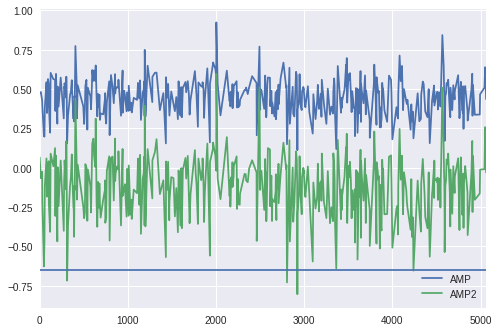

In [34]:
ax = resume.plot()
ax.axhline(-0.65)